## Dependencies

In [ ]:
%pip install rdkit
%pip install lazypredict
%pip install umap-learn
%pip install git+https://github.com/samoturk/mol2vec
%pip install optuna

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-fmxcs52s
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-fmxcs52s
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
  Using cached optuna-4.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from itertools import product


from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import MACCSkeys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from mol2vec import features
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from lightgbm import LGBMRegressor
from gensim.models import Word2Vec

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Data preparation

Проверю данные датасета, их качество и количество:

In [ ]:
df = pd.read_csv('boiling_points.csv')
df.head()

,smiles,value,source,name,units,params
0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,500.00,ECHA,Boiling point,°C,NaN
1,Cc1ccc(C=CCl)cc1,223.00,NaN,Boiling point,°C,NaN
2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,929.62,NaN,Boiling point,°C,NaN
3,CC=Cc1ccc(OCC)cc1,242.00,NaN,Boiling point,°C,NaN
4,CCCCCCCCCCc1cccc2ccccc12,379.00,Handbook of chemistry and physics 2016,Boiling point,°C,NaN


In [ ]:
df.shape

(11699, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11699 entries, 0 to 11698
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  11699 non-null  object 
 1   value   11699 non-null  float64
 2   source  7854 non-null   object 
 3   name    11699 non-null  object 
 4   units   11699 non-null  object 
 5   params  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 548.5+ KB


In [ ]:
df.describe()

,value,params
count,11699.00,0.00
mean,225.68,NaN
std,118.29,NaN
min,-191.50,NaN
25%,151.00,NaN
50%,218.00,NaN
75%,282.98,NaN
max,2262.00,NaN


Посмотрю, сколько дубликатов smiles

In [ ]:
repeated_smiles = df[df.smiles.duplicated()].smiles.unique()
len(repeated_smiles)

0

Визуализация выбросов по правилу 3-х сигм

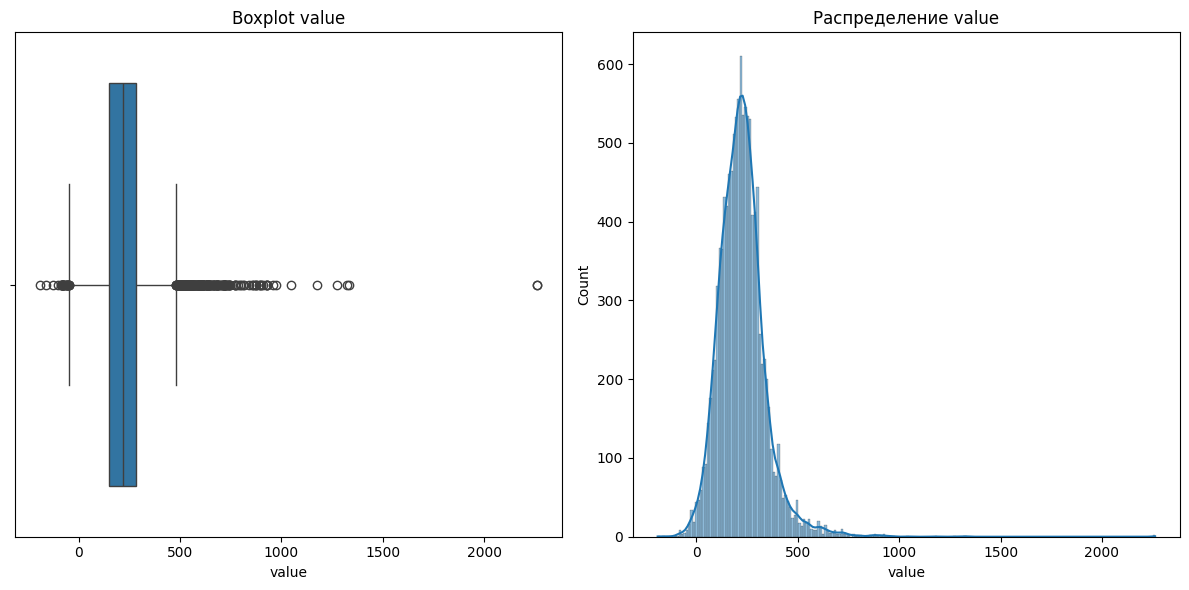

In [ ]:
def plot_outliers(df, target_col='value'):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[target_col])
    plt.title(f'Boxplot {target_col}')

    plt.subplot(1, 2, 2)
    sns.histplot(df[target_col], kde=True)
    plt.title(f'Распределение {target_col}')
    plt.tight_layout()
    plt.show()

plot_outliers(df, 'value')

Удалю выбросы

Найдено 152 выбросов в value


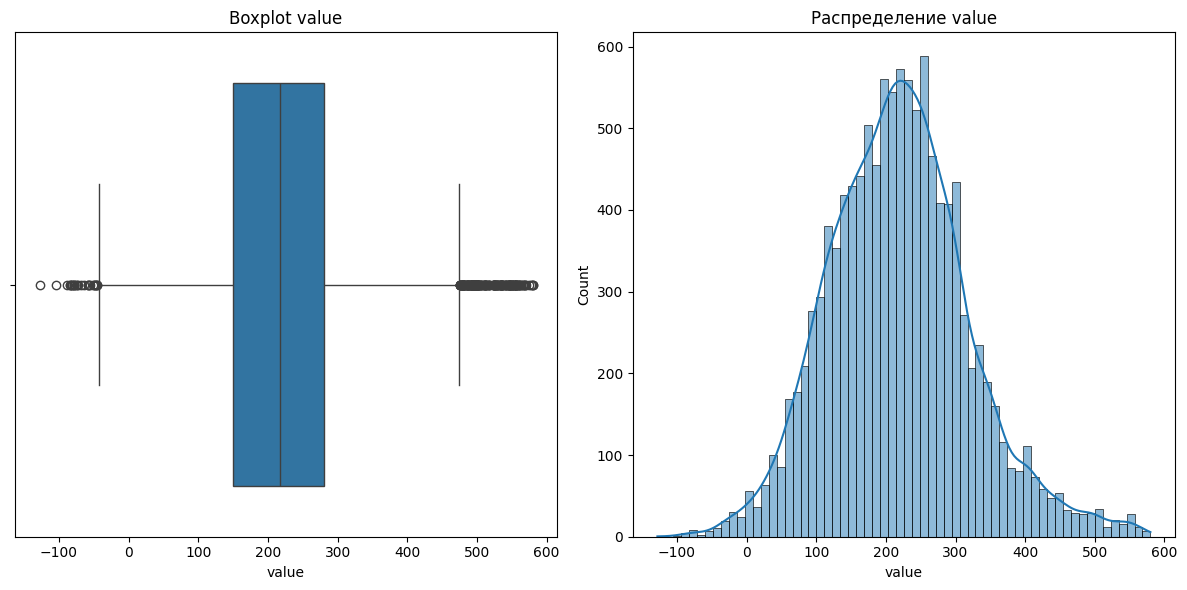

Выходные данные были обрезаны до нескольких последних строк (5000).
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use MorganGenerator
[14:19:36] DEPRECATION WARNING: please use Morg

Финальный размер данных:
X shape: (11547, 256)
y_bp shape: (11547,)


[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerator
[14:19:39] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
def remove_outliers(data, target_col, threshold=3):
    mean = data[target_col].mean()
    std = data[target_col].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    outliers = data[(data[target_col] < lower_bound) | (data[target_col] > upper_bound)]
    print(f"Найдено {len(outliers)} выбросов в {target_col}")
    return data[(data[target_col] >= lower_bound) & (data[target_col] <= upper_bound)]

df_clean = remove_outliers(df, 'value')
plot_outliers(df_clean, 'value')

def smiles_to_fp(smiles_list, radius=3, n_bits=256):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fps.append(np.array(fp))
        else:
            fps.append(np.zeros(n_bits))
    return np.vstack(fps)

X = smiles_to_fp(df_clean['smiles'])
y_bp = df_clean['value'].values

print("Финальный размер данных:")
print(f"X shape: {X.shape}")
print(f"y_bp shape: {y_bp.shape}")

In [ ]:
df_clean.shape

(11547, 6)

# Morgan fingerprints

Перевод smiles в fingerprints

In [ ]:
def get_fingerprint(smiles):
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [ ]:
df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)

Выходные данные были обрезаны до нескольких последних строк (5000).
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use MorganGenerator
[15:05:18] DEPRECATION WARNING: please use Morg

In [ ]:
X = np.stack(df_clean.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df_clean['value']

Разделение данные на train и test

In [ ]:
# 1. Сначала разделим данные на train и temp (test + validation) с соотношением 0.8 и 0.2 соответственно
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Далее разделим temp на test и validation с соотношением 50% на 50%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Возьму для подбора модели МО Lazy Predict

Добавлю дескрипторы

In [ ]:
def get_fingerprint(smiles, radius=2, n_bits=256):
    fp_array = np.zeros((0,), dtype=np.int8)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    ConvertToNumpyArray(fp, fp_array)
    return fp_array

def get_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(5)

    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAmideBonds(mol)
    ]
    return np.array(descriptors)

df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

Выходные данные были обрезаны до нескольких последних строк (5000).
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use MorganGenerator
[15:05:38] DEPRECATION WARNING: please use Morg

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1621
[LightGBM] [Info] Number of data points in the train set: 9237, number of used features: 264
[LightGBM] [Info] Start training from score 219.005372


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.58,0.68,56.13,30.75
ExtraTreesRegressor,0.58,0.67,56.31,40.32
HistGradientBoostingRegressor,0.57,0.67,56.76,3.40
LGBMRegressor,0.57,0.67,56.80,0.69
BaggingRegressor,0.55,0.66,57.94,2.88
XGBRegressor,0.55,0.65,58.41,1.40
GradientBoostingRegressor,0.54,0.64,59.02,8.39
MLPRegressor,0.50,0.61,61.49,30.93
LassoCV,0.35,0.50,69.97,2.47


Вывод: RandomForestRegressor - лучшая модель, выбираю ее в качестве модели МО.

Подбор гиперпараметров на лучшей модели

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-08-19 15:14:50,005] A new study created in memory with name: no-name-e5b64111-ba56-4f31-bc16-b6d2dab09af2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-19 15:14:52,664] Trial 0 finished with value: 4912.257628167535 and parameters: {'n_estimators': 94, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 4912.257628167535.
[I 2025-08-19 15:14:55,568] Trial 1 finished with value: 4204.443562739092 and parameters: {'n_estimators': 280, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 4204.443562739092.
[I 2025-08-19 15:14:56,510] Trial 2 finished with value: 4445.117760237819 and parameters: {'n_estimators': 93, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 4204.443562739092.
[I 2025-08-19 15:14:57,172] Trial 3 finished with value: 5814.781786279938 and parameters: {'n_estimators': 115, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': '

Подбор параметров для Morgan fingerprints

In [ ]:
radius = [2, 3]
nbits = [128, 256, 512, 1024]

In [ ]:
hgbm = RandomForestRegressor(random_state=0)

In [ ]:
best_score = 0
best_params = None

for r in radius:
  for b in nbits:

    def get_fingerprint(smiles):
      fp_array = np.zeros((0,), dtype=np.int8)
      mol = Chem.MolFromSmiles(smiles)
      fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=b)
      ConvertToNumpyArray(fp, fp_array)
      return fp_array

    hgbm.fit(X_train, y_train)
    score = hgbm.score(X_val, y_val)

    print(f'r={r}, nBits={b}, score={score}')

    if score > best_score:
      best_score = score
      best_params = (r, b)

print("Максимальный score:", best_score)
print("Параметры с максимальным score (r, nBits):", best_params)

r=2, nBits=128, score=0.6749977903131652
r=2, nBits=256, score=0.6749977903131652
r=2, nBits=512, score=0.6749977903131652
r=2, nBits=1024, score=0.6749977903131652
r=3, nBits=128, score=0.6749977903131652
r=3, nBits=256, score=0.6749977903131652
r=3, nBits=512, score=0.6749977903131652
r=3, nBits=1024, score=0.6749977903131652
Максимальный score: 0.6749977903131652
Параметры с максимальным score (r, nBits): (2, 128)


Обучение модели:

In [ ]:
best_params = study.best_params

r = 2
nBits = 128

def get_fingerprint(smiles):
    fp_array = np.zeros((0,), dtype=np.int8)
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    ConvertToNumpyArray(fp, fp_array)
    return fp_array

df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X, y)

y_train_pred = model.predict(X)
train_r2 = r2_score(y, y_train_pred)
train_mse = mean_squared_error(y, y_train_pred)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train R^2:", train_r2)
print("Train MSE:", train_mse)
print("Test R^2:", test_r2)
print("Test MSE:", test_mse)

Выходные данные были обрезаны до нескольких последних строк (5000).
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use MorganGenerator
[15:53:28] DEPRECATION WARNING: please use Morg

Train R^2: 0.898774972534762
Train MSE: 1029.3233914775155
Test R^2: 0.8902913901992155
Test MSE: 1172.9881046646447


Сохранение полученной модели

In [ ]:
import pickle
model_filename = "/content/drive/MyDrive/Syntelly/trained_model2_boiling_points.pkl"

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

Кросс-валидация:

In [ ]:
model = LGBMRegressor()

cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_results = np.sqrt(-cv_results)
print(f'Mean RMSE: {np.mean(cv_results)}, Std RMSE: {np.std(cv_results)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 136
[LightGBM] [Info] Start training from score 218.457374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 136
[LightGBM] [Info] Start training from score 218.883465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

Вывод: с данными фингепринтами и этой моделью МО RandomForestRegressor, метрики наиболее хорошие. Значит, эта модель наиболее качеcтвенная.

# Mol2Vec
Mol2vec - an unsupervised machine learning approach to learn vector representations of molecular substructures.

In [ ]:
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [ ]:
mols = [Chem.MolFromSmiles(smi) for smi in df_clean['smiles']]

[16:27:22] WARNING: not removing hydrogen atom without neighbors
[16:27:22] WARNING: not removing hydrogen atom without neighbors
[16:27:22] WARNING: not removing hydrogen atom without neighbors
[16:27:22] WARNING: not removing hydrogen atom without neighbors
[16:27:23] WARNING: not removing hydrogen atom without neighbors
[16:27:23] WARNING: not removing hydrogen atom without neighbors
[16:27:23] WARNING: not removing hydrogen atom without neighbors


In [ ]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [ ]:
def sentences2vec_word2vec(sentences, model, unseen='UNK'):
    vectors = []
    vector_size = model.vector_size

    for sentence in sentences:
        sentence_vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
            else:
                if unseen is not None and unseen in model.wv.key_to_index:
                    sentence_vec.append(model.wv[unseen])
                else:
                    sentence_vec.append(np.zeros(vector_size))

        if sentence_vec:
            vectors.append(np.mean(sentence_vec, axis=0))
        else:
            vectors.append(np.zeros(vector_size))
    return vectors

df_clean['sentence'] = [mol2alt_sentence(m, 1) for m in mols]
mol2vec_vectors = sentences2vec_word2vec(df_clean['sentence'], model, unseen='UNK')
df_clean['mol2vec'] = mol2vec_vectors

df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_mol2vec = np.stack(df_clean['mol2vec'].values)
X_desc = np.stack(df_clean['descriptors'].values)
X = np.hstack([X_mol2vec, X_desc])

y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Выходные данные были обрезаны до нескольких последних строк (5000).
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use MorganGenerator
[16:29:08] DEPRECATION WARNING: please use Morg

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26353
[LightGBM] [Info] Number of data points in the train set: 9237, number of used features: 108
[LightGBM] [Info] Start training from score 219.005372


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
MLPRegressor,0.63,0.67,59.50,17.75
HistGradientBoostingRegressor,0.63,0.67,59.80,2.92
RandomForestRegressor,0.63,0.66,59.91,140.20
LGBMRegressor,0.63,0.66,60.02,2.14
ExtraTreesRegressor,0.62,0.66,60.49,31.53
BaggingRegressor,0.61,0.64,61.74,14.16
GradientBoostingRegressor,0.60,0.64,62.07,52.40
XGBRegressor,0.60,0.63,62.54,9.57
TransformedTargetRegressor,0.53,0.58,67.34,0.52


Вывод: MLPRegressor - лучшая модель

Подбор гиперпараметров модели:

In [ ]:
from sklearn.neural_network import MLPRegressor

def objective(trial):
    params = {
        'hidden_layer_sizes': (trial.suggest_int('units', 50, 150),),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'solver': 'adam',
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, log=True),
        'max_iter': 200,
        'early_stopping': True,
        'random_state': 42
    }

    model = MLPRegressor(**params)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"{key:>20}: {value}")
print(f"Лучший R²: {study.best_value:.4f}")

[I 2025-08-19 17:16:12,478] A new study created in memory with name: no-name-6ed4ac24-f4b9-4df7-ae20-e28a2b7dee4e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-19 17:17:09,155] Trial 0 finished with value: 0.6673130295348977 and parameters: {'units': 145, 'activation': 'relu', 'alpha': 0.0878953181388084, 'learning_rate_init': 0.0016462844724344484}. Best is trial 0 with value: 0.6673130295348977.
[I 2025-08-19 17:17:35,191] Trial 1 finished with value: 0.6408118887110584 and parameters: {'units': 78, 'activation': 'logistic', 'alpha': 0.00018932852755955586, 'learning_rate_init': 0.014180891606663013}. Best is trial 0 with value: 0.6673130295348977.
[I 2025-08-19 17:18:09,520] Trial 2 finished with value: 0.6241839785324867 and parameters: {'units': 137, 'activation': 'tanh', 'alpha': 0.019186766836748356, 'learning_rate_init': 0.013527093260172783}. Best is trial 0 with value: 0.6673130295348977.
[I 2025-08-19 17:18:36,811] Trial 3 finished with value: 0.658041013681812 and parameters: {'units': 73, 'activation': 'relu', 'alpha': 0.00011021864533722456, 'learning_rate_init': 0.005955526188388753}. Best is trial 0 with value: 0.66

Обучение модели:

In [ ]:
best_params = {
    'activation': 'logistic',
    'alpha': 0.001111074189203241,
    'learning_rate_init': 0.004397285595851574,
    'solver': 'adam',
    'max_iter': 200,
    'early_stopping': True,
    'random_state': 42
}

best_model = MLPRegressor(**best_params)
best_model.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.001111074189203241,
             early_stopping=True, learning_rate_init=0.004397285595851574,
             random_state=42)

In [ ]:
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train R^2:", train_r2)
print("Train MSE:", train_mse)
print("Test R^2:", test_r2)
print("Test MSE:", test_mse)

Train R^2: 0.706552487932638
Train MSE: 2980.6873117716887
Test R^2: 0.6598084697282389
Test MSE: 3637.2771384218627


# MACCS keys fingerprints

In [ ]:
def get_maccs_keys(smiles):
    """Converts SMILES into MACCS keys fingerprint."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = MACCSkeys.GenMACCSKeys(mol)
        return list(fp)
    else:
        return [0] * 167  # MACCS keys имеют фиксированную длину 167 бит


In [ ]:
df_clean['maccs'] = df_clean['smiles'].apply(get_maccs_keys)

X = np.stack(df_clean.maccs.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df_clean['value']

# 1. Сначала разделим данные на train и temp (test + validation) с соотношением 0.8 и 0.2 соответственно
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Далее разделим temp на test и validation с соотношением 50% на 50%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

[18:10:06] WARNING: not removing hydrogen atom without neighbors
[18:10:06] WARNING: not removing hydrogen atom without neighbors
[18:10:07] WARNING: not removing hydrogen atom without neighbors
[18:10:07] WARNING: not removing hydrogen atom without neighbors
[18:10:10] WARNING: not removing hydrogen atom without neighbors
[18:10:10] WARNING: not removing hydrogen atom without neighbors
[18:10:13] WARNING: not removing hydrogen atom without neighbors


Подбор модели МО:

In [ ]:
def get_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(5)

    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAmideBonds(mol)
    ]
    return np.array(descriptors)

df_clean['fp'] = df_clean['smiles'].apply(get_maccs_keys)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)
models

[18:10:24] WARNING: not removing hydrogen atom without neighbors
[18:10:24] WARNING: not removing hydrogen atom without neighbors
[18:10:24] WARNING: not removing hydrogen atom without neighbors
[18:10:24] WARNING: not removing hydrogen atom without neighbors
[18:10:28] WARNING: not removing hydrogen atom without neighbors
[18:10:28] WARNING: not removing hydrogen atom without neighbors
[18:10:31] WARNING: not removing hydrogen atom without neighbors
[18:10:36] WARNING: not removing hydrogen atom without neighbors
[18:10:36] WARNING: not removing hydrogen atom without neighbors
[18:10:36] WARNING: not removing hydrogen atom without neighbors
[18:10:36] WARNING: not removing hydrogen atom without neighbors
[18:10:38] WARNING: not removing hydrogen atom without neighbors
[18:10:38] WARNING: not removing hydrogen atom without neighbors
[18:10:40] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 9237, number of used features: 163
[LightGBM] [Info] Start training from score 219.005372


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.63,0.69,54.99,2.36
RandomForestRegressor,0.63,0.69,55.21,18.91
LGBMRegressor,0.63,0.68,55.56,0.86
XGBRegressor,0.62,0.67,56.28,0.93
MLPRegressor,0.61,0.67,57.00,23.54
ExtraTreesRegressor,0.59,0.66,57.85,23.27
GradientBoostingRegressor,0.59,0.65,57.97,6.85
BaggingRegressor,0.58,0.65,58.71,1.91
ElasticNetCV,0.47,0.55,66.27,1.04


Вывод: HistGradientBoostingRegressor - лучшая модель.

Гиперпараметров подбор:

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'max_bins': trial.suggest_int('max_bins', 64, 255),
        'early_stopping': True,
        'random_state': 42
    }

    model = HistGradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"{key:>20}: {value}")

[I 2025-08-19 18:16:59,390] A new study created in memory with name: no-name-7ecaefd3-87c4-4201-957f-a7b7bcb538c5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-19 18:17:00,496] Trial 0 finished with value: 3072.518319217167 and parameters: {'learning_rate': 0.21223000221122093, 'max_iter': 302, 'max_depth': 12, 'min_samples_leaf': 21, 'l2_regularization': 0.10455101057014227, 'max_bins': 106}. Best is trial 0 with value: 3072.518319217167.
[I 2025-08-19 18:17:01,561] Trial 1 finished with value: 3125.9884661102246 and parameters: {'learning_rate': 0.2014994676492303, 'max_iter': 66, 'max_depth': 8, 'min_samples_leaf': 38, 'l2_regularization': 0.21447075402956683, 'max_bins': 155}. Best is trial 0 with value: 3072.518319217167.
[I 2025-08-19 18:17:03,394] Trial 2 finished with value: 3118.2501362412086 and parameters: {'learning_rate': 0.07465826913265927, 'max_iter': 92, 'max_depth': 12, 'min_samples_leaf': 95, 'l2_regularization': 0.3645186977106545, 'max_bins': 171}. Best is trial 0 with value: 3072.518319217167.
[I 2025-08-19 18:17:08,877] Trial 3 finished with value: 3259.700080265242 and parameters: {'learning_rate': 0.0146150

Обучение модели с дексрипторами

In [ ]:
best_params = study.best_params

model = HistGradientBoostingRegressor(**best_params)
model.fit(X, y)

y_train_pred = model.predict(X)
train_r2 = r2_score(y, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Результаты LGBMRegressor:")
print(f"Train R²: {train_r2:.4f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Разница Train-Test R²: {train_r2 - test_r2:.4f}")

Результаты LGBMRegressor:
Train R²: 0.7688
Train RMSE: 48.48
Test R²: 0.7548
Test RMSE: 50.04
Разница Train-Test R²: 0.0141
